In [1]:
import numpy as np
import glob
from numba import set_num_threads
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from nbody import Particles, NbodySimulation

# N-Body Simulations

In this notebook, we will run a N particles simulation which randomly initialized with normal distribution.

In [2]:
problem_name = "random_debug"

First, we should create a function to initialize N particles:

In [3]:
def initialRandomParticles(N):
        """
        Initial particles

        """

        return particles

Once partciles are initialized, we could simply call our solver to solve it. 

In [4]:
# Initial particles here.

# Run the n-body simulations

### Visualization

load data

In [5]:
fns = "data_"+problem_name+"/"+problem_name+"_[0-9][0-9][0-9][0-9][0-9].txt"
fns = glob.glob(fns)
fns.sort()

save to a movie

MovieWriter ffmpeg unavailable; using Pillow instead.


IndexError: list index out of range

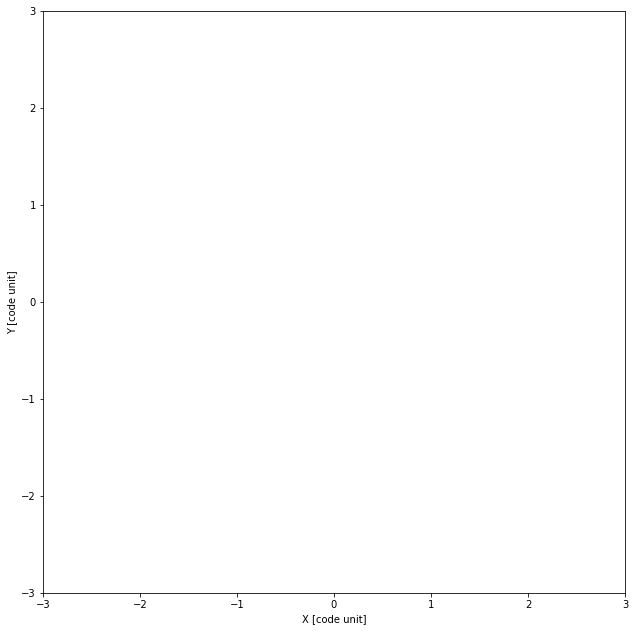

In [6]:
scale = 3 

fig, ax =plt.subplots()
fig.set_size_inches(10.5, 10.5, forward=True)
fig.set_dpi(72)
line, = ax.plot([],[],'o')

def init():
    ax.set_xlim(-1*scale,1*scale)
    ax.set_ylim(-1*scale,1*scale)
    ax.set_aspect('equal')
    ax.set_xlabel('X [code unit]')
    ax.set_ylabel('Y [code unit]')
    return line,

def updateParticles(frame):
    fn = fns[frame]
    m,t,x,y,z,vx,vy,vz,ax,ay,az = np.loadtxt(fn)
    #print("loadtxt done",fn)
    line.set_data(x,y)
    plt.title("Step ="+str(frame))
    return line,

ani = animation.FuncAnimation(fig, updateParticles, frames=len(fns),init_func=init, blit=True)
ani.save('movie_'+problem_name+'.mp4',fps=10)

# Performance

Or N-body code looks fine now. It is the time to measure the performance.


In [ ]:
%timeit sim.evolve(dt=0.01,tmax=1)

It is quite slow!!! 

Beacuse the accerlation calculations requires order of NxN calculations!
Could we improve it?

First, we should avoid the two "for" loops in the calculation using python.\
Second, we have many cup cores in our machine. Could we parallelize it?

### 1. use `numba` to speed up

note. you might need to install numba by `conda install numba`.

Step 0. See the jupyer notebook `2_1_numba_tutorial.ipynb`.

Step 1. Seperate the function to calculate the accerlation in a pure function that only counts math calculations.

Step 2. Use the `numba`'s `@jit` micro. 

Results: In my experiments. I got roughly x140 speed up with the @jit(nopython=True). 

Step 3. Try using `@njit` and `prange` in numba.

In [ ]:
%timeit sim.evolve(dt=0.02,tmax=1)

### Kuo-Chuan's measurements.

For 1000 particles and running for 50 steps

without `numba` (estimated from 5 step calculations)\
`2min 10s ± 2.47 s per loop (mean ± std. dev. of 7 runs, 1 loop each)`.\
It costs roughly, `1300 s` for 50 steps. 

with `numba`'s `@jit`.\
`7.98 s ± 67.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)`
( x162 speedup)

with `numba`'s `@njit(parallel=True)` and `prange`

cores
```
1   8.06 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2   5.9 s ± 54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4   3.84 s ± 72.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8   2.34 s ± 32.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
12  1.79 s ± 34.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
16  1.66 s ± 72.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```